# Major Map: An AI-Powered Academic Planner and Predictor for SJSU Students

## 1. Data Loading

In [ ]:
!rm -rf major_map
!git clone https://github.com/7HE-LUCKY-FISH/major_map.git

Cloning into 'major_map'...
remote: Enumerating objects: 546, done.
remote: Counting objects: 100% (286/286), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 546 (delta 109), reused 155 (delta 48), pack-reused 260 (from 1)
Receiving objects: 100% (546/546), 1.24 MiB | 15.50 MiB/s, done.
Resolving deltas: 100% (177/177), done.


In [ ]:
!ls /content/

major_map  sample_data


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from pathlib import Path

In [ ]:
# Path to repo in Colab
data_dir = Path("major_map/data/csv_data")

# Get all csv files
csv_files = sorted(data_dir.glob("*.csv"))

print("Found CSV files:")
for f in csv_files:
    print(" -", f.name)

# Combine all the csv files into one
# Check method number 4: https://medium.com/@stella96joshua/how-to-combine-multiple-csv-files-using-python-for-your-analysis-a88017c6ff9e
df_original = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

Found CSV files:
 - Fall-2022.csv
 - Fall-2023.csv
 - Fall-2024.csv
 - Spring-2022.csv
 - Spring-2023.csv
 - Spring-2024.csv
 - Spring-2025.csv


## 2. Data Understanding

### 2a. Basic Inspection

In [ ]:
df_original.head()

,Section,Number,Mode,Title,Satifies,Unit,Type,Days,Times,Instructor,Location,Dates,Seats,Year,Semester
0,BIOL 10 (Section 01),40529,In Person,The Living World,GE: B2,3,LEC,TR,09:00AM-10:15AM,Allison Harness,SCI164,08/19/22-12/06/22,59,2022,Fall
1,BIOL 10 (Section 03),40060,In Person,The Living World,GE: B2,3,LEC,MW,10:30AM-11:45AM,Phillip Hawkins,SCI164,08/19/22-12/06/22,42,2022,Fall
2,BIOL 10 (Section 04),47603,Fully Online,The Living World,GE: B2,3,LEC,TBA,TBA,Phillip Hawkins,ONLINE,08/19/22-12/06/22,6,2022,Fall
3,BIOL 10 (Section 99),41828,Fully Online,The Living World,GE: B2,3,LEC,TBA,TBA,Mary Poffenroth,ONLINE,08/19/22-12/06/22,1,2022,Fall
4,CHEM 1A (Section 01),40081,In Person,General Chemistry,GE: B1+B3,5,LEC,MWF,09:30AM-10:20AM,Resa Kelly,SCI142,08/19/22-12/06/22,0,2022,Fall


In [ ]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007 entries, 0 to 4006
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Section     4007 non-null   object
 1   Number      4007 non-null   int64 
 2   Mode        4007 non-null   object
 3   Title       4007 non-null   object
 4   Satifies    1615 non-null   object
 5   Unit        4007 non-null   int64 
 6   Type        4007 non-null   object
 7   Days        4007 non-null   object
 8   Times       4007 non-null   object
 9   Instructor  4007 non-null   object
 10  Location    3945 non-null   object
 11  Dates       4007 non-null   object
 12  Seats       4007 non-null   int64 
 13  Year        4007 non-null   int64 
 14  Semester    4007 non-null   object
dtypes: int64(4), object(11)
memory usage: 469.7+ KB


In [ ]:
df_original['Year'].value_counts()

,count
Year,
2024,1191
2022,1127
2023,1115
2025,574


In [ ]:
df_original['Semester'].value_counts()

,count
Semester,
Spring,2160
Fall,1847


In [ ]:
df_original['Instructor'].nunique()

646

In [ ]:
df_original['Section'].nunique()

980

### 2b. Check Missing / Special Values

In [ ]:
df_original['Times'].value_counts().head(10)

,count
Times,
10:30AM-11:45AM,371
12:00PM-01:15PM,366
09:00AM-10:15AM,316
01:30PM-02:45PM,300
03:00PM-04:15PM,263
04:30PM-05:45PM,185
06:00PM-08:45PM,138
TBA,102
09:00AM-11:45AM,102


In [ ]:
df_original['Days'].value_counts().head(10)

,count
Days,
MW,1120
TR,989
F,400
T,343
W,310
R,289
M,229
MTWR,113
TBA,102


In [ ]:
print(df_original['Instructor'].value_counts())
print('\n-----------------------------\n')
print(df_original['Section'].value_counts())
print('\n-----------------------------\n')
print(df_original['Semester'].value_counts())

Instructor
Richard Low                                 53
Padmavati Tanniru                           52
Alla Petrosyan                              51
Olga Kovaleva                               48
Medha Bodas                                 47
                                            ..
Neomi Millan                                 1
Peter Beyersdorf / Kenneth Wharton           1
Ehsan Khatami                                1
Nargis Adham / Azadeh Shahid Faylienejad     1
Resa Kelly                                   1
Name: count, Length: 646, dtype: int64

-----------------------------

Section
ENGR 100W (Section 16)    14
ENGR 100W (Section 14)    14
ENGR 100W (Section 06)    14
ENGR 100W (Section 18)    11
ENGR 100W (Section 12)    10
                          ..
CMPE 165 (Section 80)      1
CS 100W (Section 84)       1
CS 146 (Section 81)        1
CS 146 (Section 82)        1
CS 147 (Section 81)        1
Name: count, Length: 980, dtype: int64

-----------------------------

Sem

## 3. Data Preprocessing

In this section we will go through each features and analyze what is the best way to preprocess the data so they can be useful to use for the machine leanring model.

In [ ]:
df_preprocess = df_original.copy()
df_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007 entries, 0 to 4006
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Section     4007 non-null   object
 1   Number      4007 non-null   int64 
 2   Mode        4007 non-null   object
 3   Title       4007 non-null   object
 4   Satifies    1615 non-null   object
 5   Unit        4007 non-null   int64 
 6   Type        4007 non-null   object
 7   Days        4007 non-null   object
 8   Times       4007 non-null   object
 9   Instructor  4007 non-null   object
 10  Location    3945 non-null   object
 11  Dates       4007 non-null   object
 12  Seats       4007 non-null   int64 
 13  Year        4007 non-null   int64 
 14  Semester    4007 non-null   object
dtypes: int64(4), object(11)
memory usage: 469.7+ KB


### 3a. "Section" Feature

Ex: BIOL 10 (Section 01)
* Just in case, convert every value in "Section" to a string type. If something was not a string (like a number or a missing value NaN), it becomes a string (NaN --> "nan").

* Removes any leading and trailing whitespaces from each string. This is so we can split "Section" into "Dept" and "CourseNumber", or just "Course".

In [ ]:
df_preprocess['Section'] = df_preprocess['Section'].astype(str).str.strip()
print("Missing Section:", df_preprocess['Section'].isna().sum())
print(df_preprocess['Section'].head())

Missing Section: 0
0    BIOL 10 (Section 01)
1    BIOL 10 (Section 03)
2    BIOL 10 (Section 04)
3    BIOL 10 (Section 99)
4    CHEM 1A (Section 01)
Name: Section, dtype: object


### 3b. "Number" Feature

Ex: 40529
* Preprocessing "Number" by ensure it's integer, and have no missing.

* "Number" feature might not be even use because this feature is not really meaningful or important.

In [ ]:
df_preprocess['Number'] = df_preprocess['Number'].astype(int)
print("Missing Number:", df_preprocess['Number'].isna().sum())
print(df_preprocess['Number'].head())


Missing Number: 0
0    40529
1    40060
2    47603
3    41828
4    40081
Name: Number, dtype: int64


### 3c. "Mode" Feature

Ex: "In Person", "Fully Online", "Hybird"

* There are only 3 unique possible values for mode. We will one-hot encoding it later.

In [ ]:
print("Unique Mode values:", df_preprocess['Mode'].unique())

Unique Mode values: ['In Person' 'Fully Online' 'Hybrid']


### 3d. "Title" Feature

Ex: "In Person", "Fully Online", "Hybird"

* Also not really important feature, but just clean it just in case.

In [ ]:
df_preprocess['Title'] = df_preprocess['Title'].astype(str).str.strip()
print("Missing Title:", df_preprocess['Title'].isna().sum())
print(df_preprocess['Title'].head())

Missing Title: 0
0     The Living World
1     The Living World
2     The Living World
3     The Living World
4    General Chemistry
Name: Title, dtype: object


### 3e. "Satifies" Feature

* Can be use to track if it satifies for GE area or not. Fill missing (NaN) which MajorOnly.

In [ ]:
print("Unique Satifies values:", df_preprocess['Satifies'].unique())
df_preprocess['Satifies'] = df_preprocess['Satifies'].fillna('MajorOnly')
print('------------------------------------------------------------')
print("Missing Satifies:", df_preprocess['Satifies'].isna().sum())

Unique Satifies values: ['GE: B2' 'GE: B1+B3' nan 'GE: S' 'GE: V' 'GE: WID' 'GE: A2' 'GE: C2'
 'GE: E' 'GE: WID+R' 'GE: B4' 'GE: 5B' 'GE: 5A+5C' 'GE: 4' 'GE: 3'
 'GE: 1A' 'GE: 3B' 'GE: WID+3' 'GE: 2']
------------------------------------------------------------
Missing Satifies: 0


### 3f. "Unit" Feature

* The unit can tell us about the hours and type of the course/section.

In [ ]:
print(df_preprocess['Unit'].value_counts().sort_index())

Unit
0     905
1     234
2      60
3    2405
4     384
5      19
Name: count, dtype: int64


### 3g. "Type" Feature

* The types are LEC, SEM and LAB. Will do one hot encoding later.

In [ ]:
print("Unique Type values:", df_preprocess['Type'].unique())

Unique Type values: ['LEC' 'SEM' 'LAB']


### 3h. "Days" Feature

* Give us the day patterns. TBA is a special flag. TBA is usually online and asyn classes.

In [ ]:
print("Missing Days:", df_preprocess['Days'].isna().sum())
print("Unique Days values:", df_preprocess['Days'].unique())
print(df_preprocess['Days'].value_counts().sort_index())

Missing Days: 0
Unique Days values: ['TR' 'MW' 'TBA' 'MWF' 'F' 'T' 'W' 'R' 'M' 'S' 'MTWR']
Days
F        400
M        229
MTWR     113
MW      1120
MWF       86
R        289
S         26
T        343
TBA      102
TR       989
W        310
Name: count, dtype: int64


### 3i. "Times" Feature

* Give the time range (start time and end time) of a section

In [ ]:
print("Missing Times:", df_preprocess['Times'].isna().sum())
print(df_preprocess['Times'].value_counts())

Missing Times: 0
Times
10:30AM-11:45AM    371
12:00PM-01:15PM    366
09:00AM-10:15AM    316
01:30PM-02:45PM    300
03:00PM-04:15PM    263
                  ... 
01:30PM-02:24PM      1
03:00PM-03:45PM      1
12:00AM-01:15AM      1
06:00PM-08:20PM      1
08:00AM-09:15AM      1
Name: count, Length: 114, dtype: int64


### 3j. "Instructor" Feature

* Give us the professor name

In [ ]:
print("Missing Instructor:", df_preprocess['Instructor'].isna().sum())
print("Number of unique instructors:", df_preprocess['Instructor'].nunique())
print(df_preprocess['Instructor'].unique)

Missing Instructor: 0
Number of unique instructors: 646
<bound method Series.unique of 0                 Allison Harness
1                 Phillip Hawkins
2                 Phillip Hawkins
3                 Mary Poffenroth
4                      Resa Kelly
                  ...            
4002    Azadeh Shahid Faylienejad
4003      Vakini Santhanakrishnan
4004               Ramen Bahuguna
4005                 Nargis Adham
4006               Ramen Bahuguna
Name: Instructor, Length: 4007, dtype: object>


### 3k. "Location" Feature

* Give us the room the lecutre is held in. Online class location is lablelled as "Online"

In [ ]:
print("Missing Location before fill:", df_preprocess['Location'].isna().sum())
df_preprocess['Location'] = df_preprocess['Location'].fillna('Unknown')
print("Missing Location after fill:", df_preprocess['Location'].isna().sum())
print('---------------------------------------------------------------')
print(df_preprocess['Location'].value_counts())
print('---------------------------------------------------------------')
print(df_preprocess['Location'].unique())

Missing Location before fill: 62
Missing Location after fill: 0
---------------------------------------------------------------
Location
ONLINE    366
MH424     143
MH224     105
MH323     101
ENG392     97
         ... 
BBC203      1
DMH161      1
BBC126      1
BBC107      1
ENG336      1
Name: count, Length: 195, dtype: int64
---------------------------------------------------------------
['SCI164' 'ONLINE' 'SCI142' 'MD101' 'DH412' 'DH506' 'DH507' 'ENG325'
 'ENG405' 'ENG337' 'ENG489' 'ENG343' 'ENG341' 'ENG286' 'ENG301' 'ENG331'
 'BBC003' 'ENG288' 'ENG206' 'CL222' 'DMH234' 'MH323' 'MH424' 'MH523'
 'MH222' 'MH223' 'SCI311' 'WSQ109' 'BBC202' 'MH225' 'MH422' 'MH233'
 'CL243' 'SCI258' 'DH450' 'DH351' 'BBC004' 'Unknown' 'ENG189' 'ENG258'
 'ENG290' 'ENG305' 'ENG345' 'ENG307' 'ENG238' 'ENG317' 'ENG319' 'ENG321'
 'ENG244' 'ENG289' 'ENG291' 'ENG376' 'BBC124' 'SH411' 'BBC121' 'BBC128'
 'BBC122' 'SH348' 'DMH354' 'BBC123' 'BBC221' 'CL316' 'BBC130' 'CL225B'
 'SH444' 'CL225A' 'BBC225' 'DMH347' 'SH4

### 3l. "Dates" Feature

* Not really important, we already have Year and Semester

In [ ]:
print("Missing Dates:", df_preprocess['Dates'].isna().sum())
print(df_preprocess['Dates'].value_counts())

Missing Dates: 0
Dates
08/21/24-12/09/24    631
08/21/23-12/06/23    626
08/19/22-12/06/22    590
01/23/25-05/12/25    574
01/24/24-05/13/24    560
01/26/22-05/16/22    537
01/25/23-05/15/23    489
Name: count, dtype: int64


### 3m. "Seats" Feature

* Number of seats left for a section. Not really useful, will drop this feature.

In [ ]:
df_preprocess['Seats'] = df_preprocess['Seats'].astype(int)
print("Missing Seats:", df_preprocess['Seats'].isna().sum())
print(df_preprocess['Seats'].describe())

Missing Seats: 0
count    4007.000000
mean        3.279760
std         9.260627
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max       181.000000
Name: Seats, dtype: float64


### 3n. "Year" Feature

* Calendar Year: should be only 2022, 2023, 2024 and 2025

In [ ]:
print("Missing Year:", df_preprocess['Year'].isna().sum())
print("Years:", df_preprocess['Year'].unique())

Missing Year: 0
Years: [2022 2023 2024 2025]


### 3o. "Semester" Feature

* Term name: We only focus on Fall and Spring (no Winter or Summer)

In [ ]:
print("Missing Semester:", df_preprocess['Semester'].isna().sum())
print("Semesters:", df_preprocess['Semester'].unique())

Missing Semester: 0
Semesters: ['Fall' 'Spring']


In [ ]:
df_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007 entries, 0 to 4006
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Section     4007 non-null   object
 1   Number      4007 non-null   int64 
 2   Mode        4007 non-null   object
 3   Title       4007 non-null   object
 4   Satifies    4007 non-null   object
 5   Unit        4007 non-null   int64 
 6   Type        4007 non-null   object
 7   Days        4007 non-null   object
 8   Times       4007 non-null   object
 9   Instructor  4007 non-null   object
 10  Location    4007 non-null   object
 11  Dates       4007 non-null   object
 12  Seats       4007 non-null   int64 
 13  Year        4007 non-null   int64 
 14  Semester    4007 non-null   object
dtypes: int64(4), object(11)
memory usage: 469.7+ KB


## 4. Data Engineering

In [ ]:
# Make a copy for data engineering
df_engineer = df_preprocess.copy()

Originally, we have a total of 15 features:
1. Section          (original)
2. Number           (original, not used as feature)
3. Mode             (original, categorical feature)
4. Title            (original, usually not used as feature in v1)
5. Satifies         (original, optional categorical feature)
6. Unit             (original, numeric feature)
7. Type             (original, categorical feature)
8. Days             (original, used to build slot, not as input feature)
9. Times            (original, used to build StartMinutes/slot)
10. Instructor      (original, used to create instructor_id target)
11. Location        (original)
12. Dates           (original, not used as feature)
13. Seats           (original)
14. Year            (original, numeric feature)
15. Semester        (original, categorical feature)

New Features we will get from data engineering:
1. Dept            (engineered from Section)
2. CourseNumber    (engineered from Section)
3. CourseCode     (engineered from Dept + CourseNumber, optional)
4. HasGE           (engineered from Satifies, 0/1 flag, optional)
5. StartMinutes    (engineered from Times)
6. EndMinutes      (engineered from Times)
7. DurationMinutes (engineered from End-Start)
7. Slot            (engineered from Days + StartMinutes, e.g. "MWF_540")
8. instructor_id   (engineered target from Instructor)
9. slot_id         (engineered target from slot)
10. Building        (engineered from Location, e.g. "SCI", "MD", "ONLINE")
12. Term            (engineered from Year + Semester, e.g. "2022_Fall")
13. SemesterIndex   (engineered from term, 0,1,2,... in time order)

---






### 4a. Section → Dept, CourseNumber, and CourseCode

In [ ]:
section = df_engineer['Section'].str.extract(r'^(\w+)\s+([^\s]+)')

df_engineer['Dept'] = section[0]
df_engineer['CourseNumber'] = section[1]
df_engineer['CourseCode'] = df_engineer['Dept'].astype(str) + ' ' + df_engineer['CourseNumber'].astype(str)
df_engineer[['Section', 'Dept', 'CourseNumber', 'CourseCode']].head()

,Section,Dept,CourseNumber,CourseCode
0,BIOL 10 (Section 01),BIOL,10,BIOL 10
1,BIOL 10 (Section 03),BIOL,10,BIOL 10
2,BIOL 10 (Section 04),BIOL,10,BIOL 10
3,BIOL 10 (Section 99),BIOL,10,BIOL 10
4,CHEM 1A (Section 01),CHEM,1A,CHEM 1A


### 4b. Times → StartMinutes and EndMinutes

* Minutes after midnight (00:00 am)

In [ ]:
def parse_time_range(s):
  if s == "TBA" or "-" not in s:
    return -1, -1, -1

  # s looks like "09:00AM-10:15AM"
  # split the start and end with '-'
  start_str, end_str = s.split('-')

  # parse each part as time
  # format='%I:%M%p'
  # %I = hour in 12-hour clock (01-12)
  # %M = minutes (00-59)
  # %p = AM/PM
  start_dt = pd.to_datetime(start_str, format='%I:%M%p')
  end_dt   = pd.to_datetime(end_str,   format='%I:%M%p')

  # convert to "minutes since midnight"
  start_min = start_dt.hour * 60 + start_dt.minute
  end_min = end_dt.hour * 60 + end_dt.minute

  # section duration
  duration_min = end_min - start_min

  return start_min, end_min, duration_min

# Apply to df_model['Times'] and create three new columns
df_engineer[['StartMinutes', 'EndMinutes', 'DurationMinutes']] = df_engineer['Times'].apply(
    lambda s: pd.Series(parse_time_range(s))
)

df_engineer[['Times', 'StartMinutes', 'EndMinutes', 'DurationMinutes']].head()


,Times,StartMinutes,EndMinutes,DurationMinutes
0,09:00AM-10:15AM,540,615,75
1,10:30AM-11:45AM,630,705,75
2,TBA,-1,-1,-1
3,TBA,-1,-1,-1
4,09:30AM-10:20AM,570,620,50


### 4c. Days + StartMinutes + EndMinutes → Slot

* This show use the day and start minute. This feature is important for schedule planning later.

* We will later turn them into Slot_ID

In [ ]:
def make_slot(row):
    days = str(row['Days']).strip()
    start = int(row['StartMinutes'])
    end   = int(row['EndMinutes'])

    # If this was a TBA row that you encoded as -1
    if start == -1 or end == -1:
        return days + '_TBA'

    return f"{days}_{start}_{end}"

df_engineer['Slot'] = df_engineer.apply(make_slot, axis=1)
df_engineer[['Days', 'Times', 'StartMinutes', 'Slot']].head()

,Days,Times,StartMinutes,Slot
0,TR,09:00AM-10:15AM,540,TR_540_615
1,MW,10:30AM-11:45AM,630,MW_630_705
2,TBA,TBA,-1,TBA_TBA
3,TBA,TBA,-1,TBA_TBA
4,MWF,09:30AM-10:20AM,570,MWF_570_620


### 4d. Satifies → HasGE

* Pretty straightforward. Class that have satifies mean it is in the major requirements. This feature can be good to create roadmaps as well as schedules later.


In [ ]:
print(df_engineer['Satifies'].unique())
print('---------------------------------------------')
# 1 if it's a GE area ("GE: ..."), 0 if MajorOnly or anything else
df_engineer['HasGE'] = df_engineer['Satifies'].astype(str).str.startswith('GE:').astype(int)
print('---------------------------------------------')
print(df_engineer[['Satifies', 'HasGE']].head())
print('---------------------------------------------')
print(df_engineer['HasGE'].value_counts())

['GE: B2' 'GE: B1+B3' 'MajorOnly' 'GE: S' 'GE: V' 'GE: WID' 'GE: A2'
 'GE: C2' 'GE: E' 'GE: WID+R' 'GE: B4' 'GE: 5B' 'GE: 5A+5C' 'GE: 4'
 'GE: 3' 'GE: 1A' 'GE: 3B' 'GE: WID+3' 'GE: 2']
---------------------------------------------
---------------------------------------------
    Satifies  HasGE
0     GE: B2      1
1     GE: B2      1
2     GE: B2      1
3     GE: B2      1
4  GE: B1+B3      1
---------------------------------------------
HasGE
0    2392
1    1615
Name: count, dtype: int64


### 4e. Location → Building

* Ex: SCI164 into SCI, and Online stays Online
* Note: MD is Morris Dailey Auditorium, the SJSU website had changed the name into Town Hall


In [ ]:
def get_building(location):
  location = str(location).strip()
  if location in ['ONLINE', 'Unknown']:
    return location

  prefix = ''
  for ch in location:
    if ch.isalpha():
      prefix += ch
    else:
      break
  return prefix if prefix else 'Unknown'

df_engineer['Building'] = df_engineer['Location'].apply(get_building)
print(df_engineer['Building'].value_counts())

Building
ENG        1159
MH          662
DH          516
ONLINE      366
SCI         314
BBC         281
SH          188
CL          176
WSQ         138
DMH          90
Unknown      62
MD           24
ISB          15
YUH           9
HGH           2
CCB           2
IS            2
DBH           1
Name: count, dtype: int64


### 4e. Year + Semester → Term

In [ ]:
df_engineer['Term'] = df_engineer['Year'].astype(str) + '_' + df_engineer['Semester'].astype(str)
df_engineer[['Year', 'Semester', 'Term']].head()

,Year,Semester,Term
0,2022,Fall,2022_Fall
1,2022,Fall,2022_Fall
2,2022,Fall,2022_Fall
3,2022,Fall,2022_Fall
4,2022,Fall,2022_Fall


### 4f. Semester → SemesterIndex

* Sort the unique terms and assing 0, 1, 2,... in time order

In [ ]:
sem_order = {'Spring': 0, 'Fall': 1}

# Unique (Year, Semester) combos
term_df = (
    df_engineer[['Year', 'Semester']]
    .drop_duplicates()
    .copy()
)


# Sort by Year, then Spring/Fall
term_df['sem_order'] = term_df['Semester'].map(sem_order)
term_df = term_df.sort_values(['Year', 'sem_order']).reset_index(drop=True)

# Assign 0,1,2,... as SemesterIndex
term_df['SemesterIndex'] = term_df.index

print(term_df)

# Merge into df_engineer
df_engineer = df_engineer.merge(
    term_df[['Year', 'Semester', 'SemesterIndex']],
    on=['Year', 'Semester'],
    how='left'
)

print(
    df_engineer[['Year', 'Semester', 'SemesterIndex']]
    .drop_duplicates()
    .sort_values('SemesterIndex')
)


   Year Semester  sem_order  SemesterIndex
0  2022   Spring          0              0
1  2022     Fall          1              1
2  2023   Spring          0              2
3  2023     Fall          1              3
4  2024   Spring          0              4
5  2024     Fall          1              5
6  2025   Spring          0              6
      Year Semester  SemesterIndex
1847  2022   Spring              0
0     2022     Fall              1
2384  2023   Spring              2
590   2023     Fall              3
2873  2024   Spring              4
1216  2024     Fall              5
3433  2025   Spring              6


### 4g. Label Encoding Targets: Instructor, Slot and CourseCode
* Encode each unique instructor, slot, and course code as an integer ID using `LabelEncoder`.

In [ ]:
instr_le = LabelEncoder()
df_engineer['Instructor_ID'] = instr_le.fit_transform(df_engineer['Instructor'])

print("Number of unique instructors:", df_engineer['Instructor_ID'].nunique())
df_engineer[['Instructor', 'Instructor_ID']].head()

Number of unique instructors: 646


,Instructor,Instructor_ID
0,Allison Harness,35
1,Phillip Hawkins,439
2,Phillip Hawkins,439
3,Mary Poffenroth,363
4,Resa Kelly,471


In [ ]:
# LabelEncode Slot → slot_id
slot_le = LabelEncoder()
df_engineer['Slot_ID'] = slot_le.fit_transform(df_engineer['Slot'])

print("Number of unique slots:", df_engineer['Slot_ID'].nunique())
df_engineer[['Slot', 'Slot_ID']].head()

Number of unique slots: 261


,Slot,Slot_ID
0,TR_540_615,180
1,MW_630_705,90
2,TBA_TBA,168
3,TBA_TBA,168
4,MWF_570_620,63


In [ ]:
course_le = LabelEncoder()
df_engineer['CourseCode_ID'] = course_le.fit_transform(df_engineer['CourseCode'])

print("Number of unique course codes:", df_engineer['CourseCode_ID'].nunique())
df_engineer[['CourseCode', 'CourseCode_ID']].head()

Number of unique course codes: 92


,CourseCode,CourseCode_ID
0,BIOL 10,0
1,BIOL 10,0
2,BIOL 10,0
3,BIOL 10,0
4,CHEM 1A,1


In [ ]:
print(df_engineer.info())
print("-------------------------------------------")
df_engineer.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007 entries, 0 to 4006
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Section          4007 non-null   object
 1   Number           4007 non-null   int64 
 2   Mode             4007 non-null   object
 3   Title            4007 non-null   object
 4   Satifies         4007 non-null   object
 5   Unit             4007 non-null   int64 
 6   Type             4007 non-null   object
 7   Days             4007 non-null   object
 8   Times            4007 non-null   object
 9   Instructor       4007 non-null   object
 10  Location         4007 non-null   object
 11  Dates            4007 non-null   object
 12  Seats            4007 non-null   int64 
 13  Year             4007 non-null   int64 
 14  Semester         4007 non-null   object
 15  Dept             4007 non-null   object
 16  CourseNumber     4007 non-null   object
 17  CourseCode       4007 non-null   

,Section,Number,Mode,Title,Satifies,Unit,Type,Days,Times,Instructor,...,EndMinutes,DurationMinutes,Slot,HasGE,Building,Term,SemesterIndex,Instructor_ID,Slot_ID,CourseCode_ID
0,BIOL 10 (Section 01),40529,In Person,The Living World,GE: B2,3,LEC,TR,09:00AM-10:15AM,Allison Harness,...,615,75,TR_540_615,1,SCI,2022_Fall,1,35,180,0
1,BIOL 10 (Section 03),40060,In Person,The Living World,GE: B2,3,LEC,MW,10:30AM-11:45AM,Phillip Hawkins,...,705,75,MW_630_705,1,SCI,2022_Fall,1,439,90,0
2,BIOL 10 (Section 04),47603,Fully Online,The Living World,GE: B2,3,LEC,TBA,TBA,Phillip Hawkins,...,-1,-1,TBA_TBA,1,ONLINE,2022_Fall,1,439,168,0
3,BIOL 10 (Section 99),41828,Fully Online,The Living World,GE: B2,3,LEC,TBA,TBA,Mary Poffenroth,...,-1,-1,TBA_TBA,1,ONLINE,2022_Fall,1,363,168,0
4,CHEM 1A (Section 01),40081,In Person,General Chemistry,GE: B1+B3,5,LEC,MWF,09:30AM-10:20AM,Resa Kelly,...,620,50,MWF_570_620,1,SCI,2022_Fall,1,471,63,1


# Targets & Scenarios

* Scenarios A: Course → Professor
  * “Who is likely to teach this course?”
  * Predict Instructor_ID
  * Input: course info (CourseCode, Dept, Unit, Mode, Type, Semester, etc)
  * Target: Instructor_ID

* Scenarios B: Course → Slot
  * When (what slot) is this course likely to be scheduled?”
  * Predict Slot_ID
  * Input: similar features as A
  * Target: Slot_ID

* Scenarios C: Professor → Course
  * What course is this professor likely to teach?
  * Predict CourseCode_ID
  * Input: Professor + Term (Instructor_ID, SemesterIndex, etc)
  * Target: CourseCode_ID

# Modeling Framework

After some research, here are the machine learning models/algorithms we want to test (based on this article: https://gursev-pirge.medium.com/performance-comparison-of-multi-class-classification-algorithms-606e8ba4e0ee)

* Decision Tree
* Random Forest
* XGBoost
* SVM
* NaiveBayes

* ARIMA/ETS (time series)
* Neural Networks

## Create DataFrame for Model

In [ ]:
df_model = df_engineer.copy()
df_model.columns

Index(['Section', 'Number', 'Mode', 'Title', 'Satifies', 'Unit', 'Type',
       'Days', 'Times', 'Instructor', 'Location', 'Dates', 'Seats', 'Year',
       'Semester', 'Dept', 'CourseNumber', 'CourseCode', 'StartMinutes',
       'EndMinutes', 'DurationMinutes', 'Slot', 'HasGE', 'Building', 'Term',
       'SemesterIndex', 'Instructor_ID', 'Slot_ID', 'CourseCode_ID'],
      dtype='object')

## Split Data by Semester Order

In [ ]:
all_terms = sorted(df_model['SemesterIndex'].unique())
print("All SemesterIndex values:", all_terms)

# Chose the 2 most recent terms as test set (Fall 2024 and Spring 2025)
test_terms = all_terms[-2:]   # last two terms
print("Test terms (SemesterIndex):", test_terms)

# Split into Train and Test set
train_mask = ~df_model['SemesterIndex'].isin(test_terms)
test_mask = df_model['SemesterIndex'].isin(test_terms)

All SemesterIndex values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Test terms (SemesterIndex): [np.int64(5), np.int64(6)]


## Run Model Function

This function will be reuse to run all models

In [ ]:
from sklearn.metrics import accuracy_score

def run_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc  = accuracy_score(y_test, y_pred_test)

    print(f"Train accuracy: {train_acc:.3f}")
    print(f"Test  accuracy: {test_acc:.3f}")

    return {
        "model": name,
        "train_acc": train_acc,
        "test_acc": test_acc
    }

## Feature Selection for Scenarios A/B and C

 0   Section:       Dropped (Reason: used to get Dept and CourseNumber)  

 1   Number:        Dropped (Reason: not useful)

 2   Mode:          Kept    (Reason: useuful to check if in-person or online)

 3   Title:         Dropped (Reason: not useful)    

 4   Satifies:      Dropped (Reason: used to get HasGE)

 5   Unit:          Kept    (Reason: useuful to check the type of class)

 6   Type:          Kept    (Reason: useuful to check lecture/seminar/lab)

 7   Days:          Dropped (Reason: used to get Slot)

 8   Times:         Dropped (Reason: used to get start and end minutes)

 9   Instructor:    Dropped (Reason: used to get Instructor_ID)    

 10  Location:      Dropped (Reason: used to get the building)  

 11  Dates:          Dropped (Reason: not useful)

 12  Seats:          Dropped (Reason: not useful)

 13  Year:           Kept    (Reason: useful to tell us which year)

 14  Semester:       Kept    (Reason: useful to tell us which Spring/Fall)

 15  Dept:           Kept    (Reason: engineered from section)

 16  CourseNumber:   Optional (Reason: engineered from section)

 17  CourseCode:     Kept    (Reason: engineered from Dept and CourseNumber)

 18  StartMinutes:   Optional    (Reason: engineered from Times)

 19  EndMinutes:     Optional     (Reason: engineered from Times)

 20  DurationMinutes: Kept  (Reason: engineered from end - start minutes)

 21  Slot:           Dropped (Reason: used to get Slot_ID)

 22  HasGE:          Kept    (Reason: engineered from Satifies)

 23  Building:       Kept    (Reason: engineered from Location)

 24  Term:           Optional(Reason: engineered from Year + Semester)

 25  SemesterIndex:  Kept    (Reason: important to calculate the time order)

 26  Instructor_ID:  Target

 27  Slot_ID:        Target

 28  CourseCode_ID:  Target

In [ ]:
# Categorical features (will be one-hot encoded)
cat_cols_AB = [
    'Dept',
    'CourseCode',
    'Mode',
    'Type',
    'Semester',
    'Building',
  ]

# Numeric features (keep as-is)
num_cols_AB = [
    'Unit',
    'Year',
    'SemesterIndex',
    'DurationMinutes',
    'HasGE'
]

feature_cols_AB = cat_cols_AB + num_cols_AB
print("Feature columns:", feature_cols_AB)

Feature columns: ['Dept', 'CourseCode', 'Mode', 'Type', 'Semester', 'Building', 'Unit', 'Year', 'SemesterIndex', 'DurationMinutes', 'HasGE']


In [ ]:
# Categorical + numeric features for professor-based model (Scenario C)
cat_cols_C = [
    'Instructor',
    'Mode',
    'Type',
    'Semester',
    'Building',
]

num_cols_C = [
    'Year',
    'SemesterIndex'
]

feature_cols_C = cat_cols_C + num_cols_C
print("Feature columns:", feature_cols_C)

Feature columns: ['Instructor', 'Mode', 'Type', 'Semester', 'Building', 'Year', 'SemesterIndex']


## Create Train and Test Set

In [ ]:
X_A = df_model[feature_cols_AB].copy()
y_A = df_model['Instructor_ID'].copy()

# One-hot encode categoricals
X_A_enc = pd.get_dummies(X_A, columns=cat_cols_AB, drop_first=False)

X_train_A = X_A_enc[train_mask]
y_train_A = y_A[train_mask]

X_test_A  = X_A_enc[test_mask]
y_test_A  = y_A[test_mask]

print("Scenario A shapes:", X_train_A.shape, X_test_A.shape)

Scenario A shapes: (2802, 136) (1205, 136)


In [ ]:
X_B = df_model[feature_cols_AB].copy()
y_B = df_model['Slot_ID'].copy()

# One-hot encode categoricals
X_B_enc = pd.get_dummies(X_B, columns=cat_cols_AB, drop_first=False)

X_train_B = X_B_enc[train_mask]
y_train_B = y_B[train_mask]

X_test_B = X_B_enc[test_mask]
y_test_B = y_B[test_mask]

print("Scenario B shapes:", X_train_B.shape, X_test_B.shape)

Scenario B shapes: (2802, 136) (1205, 136)


In [ ]:
X_C = df_model[feature_cols_C].copy()
y_C = df_model['CourseCode_ID'].copy()

# One-hot encode categoricals
X_C_enc = pd.get_dummies(X_C, columns=cat_cols_C, drop_first=False)

X_train_C = X_C_enc[train_mask]
y_train_C = y_C[train_mask]

X_test_C  = X_C_enc[test_mask]
y_test_C  = y_C[test_mask]

print("Scenario C shapes:", X_train_C.shape, X_test_C.shape)

Scenario C shapes: (2802, 674) (1205, 674)


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt_instr = DecisionTreeClassifier(
    max_depth=15,      # limit depth to avoid insane overfitting
    min_samples_split=10,
    random_state=42
)

dt_A_results = run_model(
    "DecisionTree – Scenario A (Instructor)",
    dt_instr,
    X_train_A, y_train_A,
    X_test_A,  y_test_A
)



=== DecisionTree – Scenario A (Instructor) ===
Train accuracy: 0.260
Test  accuracy: 0.135


In [ ]:
dt_slot = DecisionTreeClassifier(
    max_depth=15,
    min_samples_split=10,
    random_state=42
)

dt_B_results = run_model(
    "DecisionTree – Scenario B (Slot)",
    dt_slot,
    X_train_B, y_train_B,
    X_test_B,  y_test_B
)



=== DecisionTree – Scenario B (Slot) ===
Train accuracy: 0.262
Test  accuracy: 0.226


In [ ]:
dt_course = DecisionTreeClassifier(
    max_depth=15,
    min_samples_split=10,
    random_state=42
)

dt_C_results = run_model(
    "DecisionTree – Scenario C (Course)",
    dt_course,
    X_train_C, y_train_C,
    X_test_C,  y_test_C
)



=== DecisionTree – Scenario C (Course) ===
Train accuracy: 0.552
Test  accuracy: 0.408


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Random Forest for Instructor
rf_instr = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

rf_A_results = run_model("RandomForest – Scenario A (Instructor)",
                         rf_instr, X_train_A, y_train_A, X_test_A, y_test_A)


=== RandomForest – Scenario A (Instructor) ===
Train accuracy: 0.521
Test  accuracy: 0.239


In [ ]:
rf_slot = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

rf_B_results = run_model("RandomForest – Scenario B (Slot)",
                         rf_slot, X_train_B, y_train_B, X_test_B, y_test_B)


=== RandomForest – Scenario B (Slot) ===
Train accuracy: 0.401
Test  accuracy: 0.211


In [ ]:
rf_course = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

rf_C_results = run_model("RandomForest – Scenario C (Course)",
                         rf_course, X_train_C, y_train_C, X_test_C, y_test_C)


=== RandomForest – Scenario C (Course) ===
Train accuracy: 0.904
Test  accuracy: 0.568


# XGBoost

* Problem: XGBoost can't handle unseen class labels
* Solution: Removes the unseen rows

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_params = dict(
    objective="multi:softprob",   # use for multi-class classification, ouput probability probability distribution over classes for each sample
    n_estimators=400,             # how many trees we build, same as random forest
    max_depth = 6,                # maximum depth of each decision tree
    learning_rate= 0.05,          # smaller learning rate = each tree makes a small correction, need more trees to reach good performance
    subsample=0.8,                # randomly samples 80% of the rows, randoness reduce overfitting and improve test perofrmance (0.8 is common)
    colsample_bytree=0.8,         # for each tree, use only 80% of the features (0.8 is a common choice)
    tree_method="hist",           # use histogram-based algorithm, much more and more efficent
    eval_metric="mlogloss",       # use multi-class log loss (cross-entropy)
    random_state=42,              # same as random forest
)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# encode labels
le = LabelEncoder()
y_train_A_enc = le.fit_transform(y_train_A)      # 0..K-1

# 2) Keep only test rows whose labels exist in train
seen_mask = y_test_A.isin(le.classes_)

# Keep only the "seen" for test input features
X_test_A_seen = X_test_A.loc[seen_mask]

# Keep only the "seen" for test ouput labels
y_test_A_seen = y_test_A.loc[seen_mask]

# Now that y_test_seen contains only isntructors that exist in training, we can encoded them
y_test_A_enc  = le.transform(y_test_A_seen)

print("Test rows kept:", seen_mask.sum(), " / dropped (unseen):", (~seen_mask).sum())

# 3) Train XGBoost multiclass
xgb_instr = XGBClassifier(**xgb_params)

xgb_A_results = run_model(
    "XGBoost – Scenario A (Instructor)",
    xgb_instr,
    X_train_A, y_train_A_enc,
    X_test_A_seen, y_test_A_enc
)


Test rows kept: 947  / dropped (unseen): 258

=== XGBoost – Scenario A (Instructor) ===
Train accuracy: 0.484
Test  accuracy: 0.283


In [ ]:
# encode labels
le = LabelEncoder()
y_train_B_enc = le.fit_transform(y_train_B)      # 0..K-1

# 2) Keep only test rows whose labels exist in train
seen_mask = y_test_B.isin(le.classes_)

# Keep only the "seen" for test input features
X_test_B_seen = X_test_B.loc[seen_mask]

# Keep only the "seen" for test ouput labels
y_test_B_seen = y_test_B.loc[seen_mask]

# Now that y_test_seen contains only isntructors that exist in training, we can encoded them
y_test_B_enc  = le.transform(y_test_B_seen)

print("Test rows kept:", seen_mask.sum(), " / dropped (unseen):", (~seen_mask).sum())

# 3) Train XGBoost multiclass
xgb_slot = XGBClassifier(**xgb_params)

xgb_B_results = run_model(
    "XGBoost – Scenario B (Slot)",
    xgb_slot,
    X_train_B, y_train_B_enc,
    X_test_B_seen, y_test_B_enc
)


Test rows kept: 1190  / dropped (unseen): 15

=== XGBoost – Scenario B (Slot) ===
Train accuracy: 0.368
Test  accuracy: 0.255


In [ ]:
# encode labels
le = LabelEncoder()
y_train_C_enc = le.fit_transform(y_train_C)      # 0..K-1

# 2) Keep only test rows whose labels exist in train
seen_mask = y_test_C.isin(le.classes_)

# Keep only the "seen" for test input features
X_test_C_seen = X_test_C.loc[seen_mask]

# Keep only the "seen" for test ouput labels
y_test_C_seen = y_test_C.loc[seen_mask]

# Now that y_test_seen contains only isntructors that exist in training, we can encoded them
y_test_C_enc  = le.transform(y_test_C_seen)

print("Test rows kept:", seen_mask.sum(), " / dropped (unseen):", (~seen_mask).sum())

# 3) Train XGBoost multiclass
xgb_course = XGBClassifier(**xgb_params)

xgb_C_results = run_model(
    "XGBoost – Scenario C (Course)",
    xgb_course,
    X_train_C, y_train_C_enc,
    X_test_C_seen, y_test_C_enc
)


Test rows kept: 1205  / dropped (unseen): 0

=== XGBoost – Scenario C (Course) ===
Train accuracy: 0.711
Test  accuracy: 0.520


# Naive Bayes
* Naive Bayes makes strong independence assumption so it is fast but trade-off with less accuracy

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
gnb_instr = GaussianNB()

naive_A_results = run_model(
    "GaussianNB – Scenario A (Instructor)",
    gnb_instr,
    X_train_A.to_numpy(),
    y_train_A,
    X_test_A.to_numpy(),
    y_test_A
)


=== GaussianNB – Scenario A (Instructor) ===
Train accuracy: 0.354
Test  accuracy: 0.189


In [ ]:
gnb_slot = GaussianNB()

naive_B_results = run_model(
    "GaussianNB – Scenario B (Slot)",
    gnb_slot,
    X_train_B.to_numpy(),
    y_train_B,
    X_test_B.to_numpy(),
    y_test_B
)



=== GaussianNB – Scenario B (Slot) ===
Train accuracy: 0.249
Test  accuracy: 0.215


In [ ]:
gnb_course = GaussianNB()

naive_C_results = run_model(
    "GaussianNB – Scenario C (Course)",
    gnb_course,
    X_train_C.to_numpy(),
    y_train_C,
    X_test_C.to_numpy(),
    y_test_C
)


=== GaussianNB – Scenario C (Course) ===
Train accuracy: 0.764
Test  accuracy: 0.516


# SVM

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
svm_instr = LinearSVC(
    max_iter=300,
    C=1.0,
    class_weight='balanced',
    random_state=42
)

svm_A_results = run_model(
    "LinearSVC – Scenario A (Instructor)",
    svm_instr,
    X_train_A,
    y_train_A,
    X_test_A,
    y_test_A
)


=== LinearSVC – Scenario A (Instructor) ===
Train accuracy: 0.377
Test  accuracy: 0.047


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
svm_slot = LinearSVC(
    max_iter=300,
    C=1.0,
    class_weight='balanced',
    random_state=42
)

svm_B_results = run_model(
    "LinearSVC – Scenario B (Slot)",
    svm_slot,
    X_train_B,
    y_train_B,
    X_test_B,
    y_test_B
)


=== LinearSVC – Scenario B (Slot) ===
Train accuracy: 0.188
Test  accuracy: 0.039


In [ ]:
svm_course = LinearSVC(
    max_iter=300,
    C=1.0,
    class_weight='balanced',
    random_state=42
)

svm_C_results = run_model(
    "LinearSVC – Scenario C (Course)",
    svm_course,
    X_train_C,
    y_train_C,
    X_test_C,
    y_test_C
)


=== LinearSVC – Scenario C (Course) ===
Train accuracy: 0.761
Test  accuracy: 0.266


# Model Comparison

In [ ]:
import pandas as pd

results = []

def add_result(res_dict, scenario_label):
    d = res_dict.copy()
    d["scenario"] = scenario_label
    results.append(d)

# ---- Scenario A: Course → Instructor ----
add_result(rf_A_results,    "A: Course → Instructor")
add_result(dt_A_results,    "A: Course → Instructor")
add_result(naive_A_results, "A: Course → Instructor")
add_result(svm_A_results,   "A: Course → Instructor")
add_result(xgb_A_results,   "A: Course → Instructor")

# ---- Scenario B: Course → Slot ----
add_result(rf_B_results,    "B: Course → Slot")
add_result(dt_B_results,    "B: Course → Slot")
add_result(naive_B_results, "B: Course → Slot")
add_result(svm_B_results,   "B: Course → Slot")
add_result(xgb_B_results,   "B: Course → Slot")

# ---- Scenario C: Professor → Course ----
add_result(rf_C_results,    "C: Prof → Course")
add_result(dt_C_results,    "C: Prof → Course")
add_result(naive_C_results, "C: Prof → Course")
add_result(svm_C_results,   "C: Prof → Course")
add_result(xgb_C_results,   "C: Prof → Course")

# Build DataFrame
df_results = pd.DataFrame(results)

# Reorder columns and round based on test accuracies
df_results = (
    df_results[["scenario", "model", "train_acc", "test_acc"]]
    .assign(
        train_acc=lambda d: d["train_acc"].round(3),
        test_acc=lambda d: d["test_acc"].round(3),
    )
    .sort_values(["scenario", "test_acc"], ascending=[True, False])
)



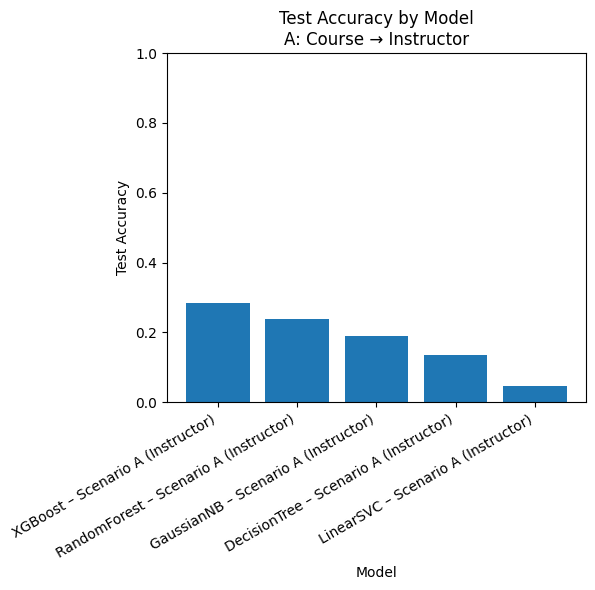

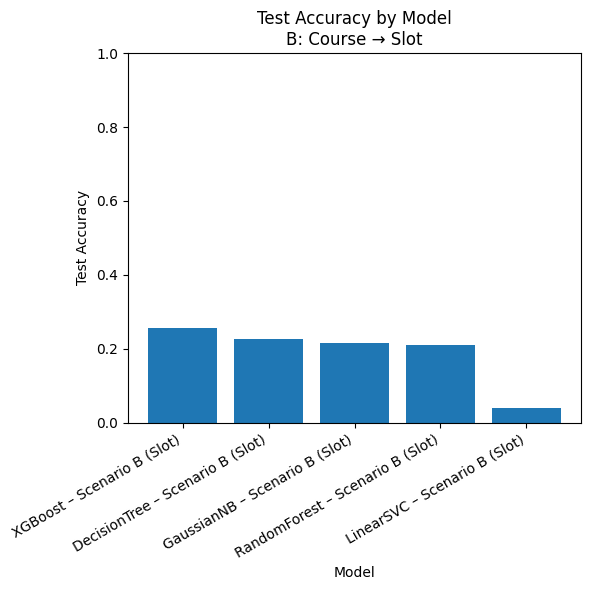

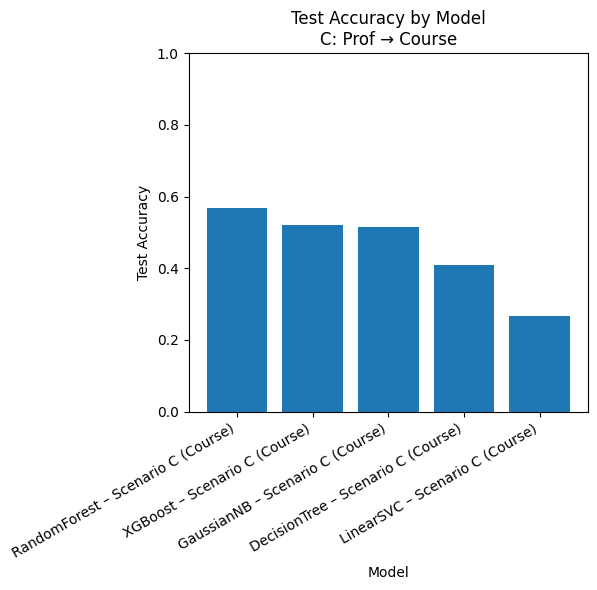

In [ ]:
import matplotlib.pyplot as plt

scenarios = df_results['scenario'].unique()

for scen in scenarios:
    sub = df_results[df_results['scenario'] == scen]

    plt.figure(figsize=(6, 6))
    plt.bar(sub['model'], sub['test_acc'])
    plt.ylim(0, 1)
    plt.title(f"Test Accuracy by Model\n{scen}")
    plt.xlabel("Model")
    plt.ylabel("Test Accuracy")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()
    print()



Across all three prediction scenarios, the model parsion show a clearn pattern that tree-based enemble models perform best. Random Forest and XGBoost consistently achieve the highest test accuracy, espaecially in Scenarios C. Single Decision Tree, and Naive Bayes have lower test accuracy and linear SVM have the lowest test accuracy overall. This show that scheduling patterns are not good to be capture by simple linear or indepedence based model.

# Top-k Accuracy

* This section is to test the website behavior where we will likely provide the top 3 likely profs/slots/courses to the user for our machine learning model prediction.

In [ ]:
import numpy as np

def topk_accuracy(model, X_test, y_test, k=3):
    proba = model.predict_proba(X_test)
    classes = model.classes_                    # actual label values
    # topk_idx: positions in the classes_ array
    topk_idx = np.argsort(proba, axis=1)[:, -k:]
    # map to actual labels
    topk_labels = classes[topk_idx]             # shape: (n_samples, k)

    y_true = y_test.to_numpy() if hasattr(y_test, "to_numpy") else np.array(y_test)
    correct = 0
    for i, true_label in enumerate(y_true):
        if true_label in topk_labels[i]:        # compare label to labels, not indices
            correct += 1
    return correct / len(y_true)

In [ ]:
top1_A = accuracy_score(y_test_A, rf_instr.predict(X_test_A))
top3_A = topk_accuracy(rf_instr, X_test_A, y_test_A, k=3)
top5_A = topk_accuracy(rf_instr, X_test_A, y_test_A, k=5)

print("Scenario A – Random Forest (Instructor)")
print("  top-1 accuracy:", round(top1_A, 3))
print("  top-3 accuracy:", round(top3_A, 3))
print("  top-5 accuracy:", round(top5_A, 3))

Scenario A – Random Forest (Instructor)
  top-1 accuracy: 0.239
  top-3 accuracy: 0.394
  top-5 accuracy: 0.485


In [ ]:
top1_B = accuracy_score(y_test_B, rf_slot.predict(X_test_B))
top3_B = topk_accuracy(rf_slot, X_test_B, y_test_B, k=3)
top5_B = topk_accuracy(rf_slot, X_test_B, y_test_B, k=5)

print("\nScenario B – Random Forest (Slot)")
print("  top-1 accuracy:", round(top1_B, 3))
print("  top-3 accuracy:", round(top3_B, 3))
print("  top-5 accuracy:", round(top5_B, 3))


Scenario B – Random Forest (Slot)
  top-1 accuracy: 0.211
  top-3 accuracy: 0.467
  top-5 accuracy: 0.622


In [ ]:
top1_C = accuracy_score(y_test_C, rf_course.predict(X_test_C))
top3_C = topk_accuracy(rf_course, X_test_C, y_test_C, k=3)
top5_C = topk_accuracy(rf_course, X_test_C, y_test_C, k=5)

print("\nScenario C – Random Forest (Course)")
print("  top-1 accuracy:", round(top1_C, 3))
print("  top-3 accuracy:", round(top3_C, 3))
print("  top-5 accuracy:", round(top5_C, 3))


Scenario C – Random Forest (Course)
  top-1 accuracy: 0.568
  top-3 accuracy: 0.771
  top-5 accuracy: 0.86


# Recency-Weighted Combined Schedule Prediction Model

## Overview

* Train the model to predict if a course will be scheduled or not
    *
    * Course: CourseCode, Instructor, Slot, and Type

* When The user picks desired course/type/time preferences, we will:
    * build a feature row for each requested course
    * run the model


## Code Implementation

In [ ]:
df_combined = df_engineer.copy()
print(df_combined.head())

                Section  Number          Mode              Title   Satifies  \
0  BIOL 10 (Section 01)   40529     In Person   The Living World     GE: B2   
1  BIOL 10 (Section 03)   40060     In Person   The Living World     GE: B2   
2  BIOL 10 (Section 04)   47603  Fully Online   The Living World     GE: B2   
3  BIOL 10 (Section 99)   41828  Fully Online   The Living World     GE: B2   
4  CHEM 1A (Section 01)   40081     In Person  General Chemistry  GE: B1+B3   

   Unit Type Days            Times       Instructor  ... EndMinutes  \
0     3  LEC   TR  09:00AM-10:15AM  Allison Harness  ...        615   
1     3  LEC   MW  10:30AM-11:45AM  Phillip Hawkins  ...        705   
2     3  LEC  TBA              TBA  Phillip Hawkins  ...         -1   
3     3  LEC  TBA              TBA  Mary Poffenroth  ...         -1   
4     5  LEC  MWF  09:30AM-10:20AM       Resa Kelly  ...        620   

  DurationMinutes         Slot  HasGE Building       Term SemesterIndex  \
0              75   TR_

In [ ]:
display(df_combined.columns)

Index(['Section', 'Number', 'Mode', 'Title', 'Satifies', 'Unit', 'Type',
       'Days', 'Times', 'Instructor', 'Location', 'Dates', 'Seats', 'Year',
       'Semester', 'Dept', 'CourseNumber', 'CourseCode', 'StartMinutes',
       'EndMinutes', 'DurationMinutes', 'Slot', 'HasGE', 'Building', 'Term',
       'SemesterIndex', 'Instructor_ID', 'Slot_ID', 'CourseCode_ID'],
      dtype='object')

### 1. Combined Model Setup

In [ ]:
df_combined['Scheduled'] = 1

# TERM AGNOSTIC MODEL
Only run if testing term agnostic model

In [ ]:
# Columns that define a "complete course"
key_cols = ['CourseCode', 'Instructor', 'Slot', 'Type']

# We'll use Dept only for negative generation constraints (not required as a model input)
helper_cols = ['Dept']

pos_raw = df_combined.copy()

# Keep only needed cols; drop missing; dedupe across ALL terms (term-agnostic)
pos = (
    pos_raw[key_cols + helper_cols]
    .dropna(subset=key_cols)
    .drop_duplicates()
    .reset_index(drop=True)
)

pos['ScheduledEver'] = 1

# Fast lookup set of "ever scheduled" combos
pos_keys = set(map(tuple, pos[key_cols].values))
print("Unique positive combos:", len(pos))

Unique positive combos: 2678


Get pools of instructors for each department
and slots for each course

In [ ]:
# Instructors historically associated with each Dept
instr_pool = (
    pos[['Dept', 'Instructor']]
    .drop_duplicates()
    .groupby('Dept')['Instructor']
    .apply(list)
)

# Slots historically used for each (CourseCode, Type)
slot_pool = (
    pos[['CourseCode', 'Type', 'Slot']]
    .drop_duplicates()
    .groupby(['CourseCode', 'Type'])['Slot']
    .apply(list)
)

In [ ]:
rng = np.random.default_rng(42)
K = 3  # negatives per positive combo
MAX_TRIES_PER_POS = 25 * K

neg_rows = []

# For each positive course we are generating 3 negatives
for _, row in pos.iterrows():
    dept = row['Dept']
    course = row['CourseCode']
    typ = row['Type']
    instr = row['Instructor']
    slot = row['Slot']

    i_pool = instr_pool.get(dept, [])
    s_pool = slot_pool.get((course, typ), [])

    # Need at least one alternative instructor OR one alternative slot to generate negatives
    if len(i_pool) < 2 and len(s_pool) < 2:
        continue

    generated = 0
    tries = 0

    # Keep going until we have K # of negatives or we exceed tries
    while generated < K and tries < MAX_TRIES_PER_POS:
        tries += 1
        new = row.copy()

        r = rng.random()

        if r < 0.50 and len(i_pool) >= 2:
            # swap instructor within dept
            choices = [i for i in i_pool if i != instr]
            if not choices:
                continue
            new['Instructor'] = rng.choice(choices)

        elif r < 0.90 and len(s_pool) >= 2:
            # swap slot within course+type feasible slots
            choices = [s for s in s_pool if s != slot]
            if not choices:
                continue
            new['Slot'] = rng.choice(choices)

        else:
            # swap both (if possible)
            if len(i_pool) >= 2:
                choices_i = [i for i in i_pool if i != instr]
                if not choices_i:
                    continue
                new['Instructor'] = rng.choice(choices_i)
            if len(s_pool) >= 2:
                choices_s = [s for s in s_pool if s != slot]
                if not choices_s:
                    continue
                new['Slot'] = rng.choice(choices_s)

        key = (new['CourseCode'], new['Instructor'], new['Slot'], new['Type'])

        # If it's a known historical combo, skip (it's actually positive)
        if key in pos_keys:
            continue

        new['ScheduledEver'] = 0
        neg_rows.append(new[key_cols + ['ScheduledEver']])
        generated += 1

neg = pd.DataFrame(neg_rows).drop_duplicates(subset=key_cols).reset_index(drop=True)

# Only taking the key cols and not helper
df_term_agnostic = pd.concat(
    [
        pos[key_cols + ['ScheduledEver']],
        neg[key_cols + ['ScheduledEver']]
    ],
    ignore_index=True
).drop_duplicates(subset=key_cols + ['ScheduledEver'])

print(df_term_agnostic['ScheduledEver'].value_counts())
print("Total labeled combos:", len(df_term_agnostic))

ScheduledEver
0    7007
1    2678
Name: count, dtype: int64
Total labeled combos: 9685


### ML Model for term agnostic dataset



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

df_model = df_term_agnostic.copy()

# Add interaction columns (still derived only from the 4 inputs)
df_model['Course_Instructor'] = df_model['CourseCode'].astype(str) + "||" + df_model['Instructor'].astype(str)
df_model['Course_Slot']       = df_model['CourseCode'].astype(str) + "||" + df_model['Slot'].astype(str)
df_model['Instructor_Slot']   = df_model['Instructor'].astype(str) + "||" + df_model['Slot'].astype(str)
df_model['Course_Type']       = df_model['CourseCode'].astype(str) + "||" + df_model['Type'].astype(str)

cat_cols = ['CourseCode', 'Instructor', 'Slot', 'Type',
            'Course_Instructor', 'Course_Slot', 'Instructor_Slot', 'Course_Type']
# cat_cols = ['CourseCode', 'Instructor', 'Slot', 'Type',]

X = df_model[cat_cols]
y = df_model['ScheduledEver'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ],
    remainder='drop'
)

clf = LogisticRegression(
    max_iter=2000,
    solver='saga',
    class_weight='balanced'
)

model = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', clf)
])

model.fit(X_train, y_train)

proba = model.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_test, proba))
print("PR AUC :", average_precision_score(y_test, proba))
print(classification_report(y_test, pred, digits=3))

ROC AUC: 0.6175759319036509
PR AUC : 0.38024427543557304
              precision    recall  f1-score   support

           0      0.780     0.732     0.755      1401
           1      0.396     0.459     0.425       536

    accuracy                          0.657      1937
   macro avg      0.588     0.596     0.590      1937
weighted avg      0.674     0.657     0.664      1937



**Note: We can adjust the prediction cut-off ratio to see how that affects results**

# Set Method (NO ML)

In [ ]:
pos_key_set = set(map(tuple, pos[key_cols].values))

def scheduled_ever_lookup(course, instructor, slot, typ):
    return int((course, instructor, slot, typ) in pos_key_set)

# TERM INCLUDED MODEL
History features added that are built from prior term information.
We only create history for the train terms to avoid leaking data into the test set. 

In [ ]:
def add_history_features_no_leak(df_labeled, df_pos_hist, term_col='SemesterIndex'):
    """
    df_labeled:     rows to featurize (train+test, includes negatives)
    df_pos_hist:    ONLY positives from TRAIN TERMS (history allowed)
    term_col:       column for ordering 
    """
    df = df_labeled.copy()
    df[term_col] = df[term_col].astype(int)

    hist = df_pos_hist.copy()
    hist[term_col] = hist[term_col].astype(int)

    # create row ID to preserve ordering after merges
    df["_row_id"] = np.arange(len(df))

    # ---- PRIOR COUNT FEATURES ----
    # what we want to count and where we are storing the counts
    feature_defs = [
        (['Instructor'],                   'instr_prior_count'),                # How many times instructor taught before
        (['CourseCode'],                   'course_prior_count'),               # How many times the course has been offered before
        (['Slot'],                         'slot_prior_count'),                 # How many times the slot has been used
        (['CourseCode','Type'],            'course_type_prior_count'),          # How many times the course has been shown with each type (Lab / Lecture)
        (['Instructor','Dept'],            'instr_dept_prior_count'),           # Instructor w/ Department Frequency
        (['Instructor','CourseCode'],      'instr_course_prior_count'),         # Instructor w/ Course Frequency
        (['CourseCode','Slot'],            'course_slot_prior_count'),          # Course w/ Time Slot Frequency
        (['CourseCode','Type','Slot'],     'course_type_slot_prior_count'),     # Course w/ Type w/ Time Slot
        (['CourseCode','Instructor','Slot','Type'], 'combo_prior_count'),       # Course w/ Instructor w/ Slot w/ Type
    ]

    for group_cols, out_col in feature_defs:
        # Count the occurrences of each group within each term
        tmp = (
            hist.groupby(group_cols + [term_col])
                .size() # Count rows
                .reset_index(name='n_in_term') # makes a column so the info is stored in a Dataframe
                .sort_values(term_col, kind="mergesort") # Sorts in order of term 
        )

        # Uses cumulative sum to get the sum up to and including the current term for each row (diff from normal sum)
        # This works since it is sorted by the term col
        tmp['cum_inclusive'] = tmp.groupby(group_cols)['n_in_term'].cumsum()

        # For merge rename the cumulative count column to the name that we want aka "out_col" 
        lookup = tmp[group_cols + [term_col, 'cum_inclusive']].rename(
            columns={'cum_inclusive': out_col}
        )

        # Sort both dataframes by term for merge_asof
        left  = df.sort_values(term_col, kind="mergesort").reset_index(drop=True)
        right = lookup.sort_values(term_col, kind="mergesort").reset_index(drop=True)

        # For each row in the left column, it tries to match it with a row in the right column and merge
        # Since we are not allowing exact matches it  uses the one with the previous term_col value
        # Data is only from the previous terms
        left = pd.merge_asof(
            left, right,
            on=term_col,
            by=group_cols,
            direction='backward',
            allow_exact_matches=False
        )

        # Fill missing (never seen before) with 0
        left[out_col] = left[out_col].fillna(0).astype(int)

        # Restore original row order
        df = left.sort_values("_row_id", kind="mergesort").reset_index(drop=True)

    # ---- LAST SEEN / RECENCY FEATURES ----
    # Track when the column / combination was last seen
    recency_defs = [
        (['Instructor'], 'instr_last_term'),                                # Last term instructor taught
        (['CourseCode'], 'course_last_term'),                               # Last term course was offered
        (['Instructor','CourseCode'], 'instr_course_last_term'),            # Last time the instructor taught that course
        (['CourseCode','Instructor','Slot','Type'], 'combo_last_term'),     # Last exact match
    ]

    for group_cols, out_col in recency_defs:
        # Get all unique term occurrences for each group
        seen = (
            hist[group_cols + [term_col]]
            .drop_duplicates()  # One row for each group per term
            .sort_values(term_col, kind="mergesort")
            .reset_index(drop=True)
        )

        # Make a copy of the term column to preserve after merging
        seen[out_col] = seen[term_col]
        seen = seen[group_cols + [term_col, out_col]]

        # Sort for the merge_asof
        left  = df.sort_values(term_col, kind="mergesort").reset_index(drop=True)
        right = seen.sort_values(term_col, kind="mergesort").reset_index(drop=True)

        # Find the most recent previous term where this group appeared
        # Merge the two, term_col of the left is kept, we gain an additional out_col from the copy we made earlier that tells you when it last appeared
        left = pd.merge_asof(
            left, right,
            on=term_col,
            by=group_cols,
            direction='backward',
            allow_exact_matches=False # only looks at previous terms
        )

        # -1 means never seen before
        left[out_col] = left[out_col].fillna(-1).astype(int)

        # rename column
        gap_col = out_col.replace('last_term', 'terms_since')

        # calculate the gap from current to last
        # ternary operator
        left[gap_col] = np.where(
            left[out_col] == -1,            # Condition
            left[term_col] + 1,             # never seen before = current term + 1 
            left[term_col] - left[out_col]  # Otherwise: current - last seen
        ).astype(int)

        # restore order
        df = left.sort_values("_row_id", kind="mergesort").reset_index(drop=True)

    # ---- LOG TRANSFORMS ----
    # apply log1p to count features to reduce skew
    count_cols = [c for c in df.columns if c.endswith('_prior_count')]
    for c in count_cols:
        df[c + '_log1p'] = np.log1p(df[c].astype(float))

    # clean up temp id column
    df.drop(columns=["_row_id"], inplace=True)
    return df

**Code starts here**

In [ ]:
# start with positive examples (actual scheduled courses)
pos = df_combined.copy()
pos['Scheduled'] = 1


# Build list of active instructors for a term + department
instr_pool = (
    pos[['SemesterIndex', 'Dept', 'Instructor']]
    .drop_duplicates()                                     # remove duplicates (if they taught multiple)
    .groupby(['SemesterIndex', 'Dept'])['Instructor']      # Instructors are put into buckets for each term + dept
    .apply(list)                                           # The buckets are made into lists
)

# Build list of slots that a course has used in the past
slot_pool = (
    pos[['CourseCode', 'Type', 'Slot']]
    .drop_duplicates()
    .groupby(['CourseCode', 'Type'])['Slot']
    .apply(list)
)

# Build a fast lookup set of positives 
# Check if a combo happened in O(1)
pos_keys = set(
    zip(pos['SemesterIndex'], pos['CourseCode'], pos['Instructor'], pos['Slot'], pos['Type'])
)

2) Generate the negatives

In [ ]:
rng = np.random.default_rng(42) # For reproducible results
K = 3  # negatives per positive row

neg_rows = [] # store all generated examplees

# loop through actual scheduled courses
for _, row in pos.iterrows():
    term = row['SemesterIndex']
    dept = row['Dept']
    course = row['CourseCode']
    typ = row['Type']
    instr = row['Instructor']
    slot = row['Slot']

    # get instructors for this term + dept
    i_pool = instr_pool.get((term, dept), [])
    # get slots for this course + type
    s_pool = slot_pool.get((course, typ), [])

    # make sure we have alternatives to create negatives from
    if len(i_pool) < 2 or len(s_pool) < 1:
        continue

    # Generate the k negatives
    for _ in range(K):
        new = row.copy() #start with real course

        # choose what to corrupt
        r = rng.random()
        if r < 0.5:
            # 50% chance to swap instructor ONLY(keep same slot)
            choices = [i for i in i_pool if i != instr]
            if not choices:
                continue
            new_instr = rng.choice(choices)
            new['Instructor'] = new_instr

        elif r < 0.9:
            # 40 % chance to swap time slot ONLY
            if len(s_pool) > 1:
                choices = [s for s in s_pool if s != slot]
                new_slot = rng.choice(choices)
            else:
                continue
            new['Slot'] = new_slot

        else:
            # 10% chance swap both
            choices_i = [i for i in i_pool if i != instr]
            if not choices_i:
                continue
            new['Instructor'] = rng.choice(choices_i)
            new['Slot'] = rng.choice(s_pool)

        # Create key to check if it matches an existing positive
        key = (new['SemesterIndex'], new['CourseCode'], new['Instructor'], new['Slot'], new['Type'])
        if key in pos_keys:
            continue  # accidentally created a real positive skip

        # Mark as negative and add it to the list
        new['Scheduled'] = 0
        neg_rows.append(new)

# Convert the array to a dataframe and remove duplicates
neg = pd.DataFrame(neg_rows).drop_duplicates(
    subset=['SemesterIndex', 'CourseCode', 'Instructor', 'Slot', 'Type']
)

# combine positives and negatives into one labeled dataset
df_labeled = pd.concat([pos, neg], ignore_index=True)
print(df_labeled['Scheduled'].value_counts())

Scheduled
0    10328
1     4007
Name: count, dtype: int64


3) Add the history features

In [ ]:
# feature columns
cat_cols = ['CourseCode', 'Instructor', 'Slot', 'Type']
# include selected history features (adjust if needed)
num_cols = [
    'instr_prior_count_log1p',
    'course_prior_count_log1p',
    'course_type_prior_count_log1p',
    'instr_course_prior_count_log1p',
    'course_type_slot_prior_count_log1p',
    'combo_prior_count_log1p',
    'instr_terms_since',
    'course_terms_since',
    'instr_course_terms_since',
    'combo_terms_since',
]

# --- time split first ---
all_terms = sorted(df_labeled['SemesterIndex'].unique())
test_terms = all_terms[-2:] #last 2 terms for test set

train_mask = ~df_labeled['SemesterIndex'].isin(test_terms)
test_mask  =  df_labeled['SemesterIndex'].isin(test_terms)

# IMPORTANT: history is built ONLY from TRAIN positives
train_pos_hist = df_labeled.loc[train_mask & (df_labeled['Scheduled'] == 1)].copy()

# compute features for ALL rows, using TRAIN history only
df_feat = add_history_features_no_leak(df_labeled, train_pos_hist, term_col='SemesterIndex')

# take df_feat and split into X and y
X = df_feat[cat_cols + num_cols].copy()
y = df_feat['Scheduled'].astype(int)

# split into train and test sets based on mask
X_train, X_test = X.loc[train_mask], X.loc[test_mask]
y_train, y_test = y.loc[train_mask], y.loc[test_mask]

4) Split the data and train the model (Logistic regression)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix

#preprocessing + model
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols), # one hot encode categorical columns 
        ('num', StandardScaler(), num_cols),                       # scale numerical columns
    ],
    remainder='drop'
)

clf = LogisticRegression(
    max_iter=2000,
    solver='saga',           # good for sparse one-hot
    class_weight='balanced'  # Automatically adjust weights inversely proportional to class frequencies 
                             # helps if negatives are much greater than positives
)

model = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', clf)
])

# train + evaluate
model.fit(X_train, y_train)

proba = model.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print("\nClassification report:\n", classification_report(y_test, pred, digits=3))
print("\nROC AUC:", roc_auc_score(y_test, proba))
print("PR AUC :", average_precision_score(y_test, proba))


Confusion matrix:
 [[2330  741]
 [ 474  731]]

Classification report:
               precision    recall  f1-score   support

           0      0.831     0.759     0.793      3071
           1      0.497     0.607     0.546      1205

    accuracy                          0.716      4276
   macro avg      0.664     0.683     0.670      4276
weighted avg      0.737     0.716     0.724      4276


ROC AUC: 0.7645865282369807
PR AUC : 0.5894107766429404


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# --- 2 preprocessing strategies ---
# For linear models: scaling helps, keep sparse-friendly scaling (with_mean=False)
preprocess_linear = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(with_mean=False), num_cols),         # doesn't center the data, only scales by standard deviation
                                                                    # helps reduce memory usage because of how sparse matrices are stored
    ],
    remainder='drop'
)

# For Naive Bayes: Don't standardize numerical features , NB assumes nonnegative
# numeric features are already nonnegative (log1p counts, terms_since), so passthrough is fine.
preprocess_nb = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols),
    ],
    remainder='drop'
)

# Helper function to train and evaluate any model
def eval_model(name, preprocess, clf, X_train, y_train, X_test, y_test):
    pipe = Pipeline([('prep', preprocess), ('clf', clf)])
    pipe.fit(X_train, y_train)

    # score for AUC/PR-AUC
    if hasattr(pipe, "predict_proba"):
        scores = pipe.predict_proba(X_test)[:, 1]   # use probabilities to get scores
        preds = (scores >= 0.5).astype(int)         # use boundary to classify predictions
    else:
        # e.g. LinearSVC, models without calibration
        scores = pipe.decision_function(X_test)
        preds = (scores >= 0).astype(int)

    # Various results from raw scores and the predictions
    print(f"\n=== {name} ===")
    print("ROC AUC:", roc_auc_score(y_test, scores))
    print("PR  AUC:", average_precision_score(y_test, scores))
    print(classification_report(y_test, preds, digits=3))
    return pipe

# list of models we are comparing
models = [
    # Elastic Net (Logistic regression, combines Lasso and ridge regularization)
    ("LogReg (ElasticNet)",
     preprocess_linear,
     LogisticRegression(
         max_iter=4000,
         solver="saga",
         penalty="elasticnet",
         l1_ratio=0.2,           # try 0.1, 0.5 too
         C=1.0,
         class_weight="balanced"
     )),

    # Linear SVM with probability calibration
    ("Linear SVM (Calibrated)",
     preprocess_linear,
     CalibratedClassifierCV(
         estimator=LinearSVC(class_weight="balanced"),
         method="sigmoid",  # sigmoid for calibration
         cv=3               # 3-fold cross-validation for calibration
     )),

    # ComplementNB (Naive bayes variant that's good for imbalanced data)
    ("ComplementNB",
     preprocess_nb,
     ComplementNB(alpha=0.5)),  # try 0.1, 1.0
]

fitted = {}
for name, prep, clf in models:
    fitted[name] = eval_model(name, prep, clf, X_train, y_train, X_test, y_test)



=== LogReg (ElasticNet) ===
ROC AUC: 0.7653628982679626
PR  AUC: 0.5904054565459627
              precision    recall  f1-score   support

           0      0.832     0.764     0.796      3071
           1      0.502     0.607     0.549      1205

    accuracy                          0.719      4276
   macro avg      0.667     0.685     0.673      4276
weighted avg      0.739     0.719     0.727      4276


=== Linear SVM (Calibrated) ===
ROC AUC: 0.7520708380229452
PR  AUC: 0.5776088056272491
              precision    recall  f1-score   support

           0      0.765     0.965     0.853      3071
           1      0.733     0.243     0.365      1205

    accuracy                          0.762      4276
   macro avg      0.749     0.604     0.609      4276
weighted avg      0.756     0.762     0.716      4276


=== ComplementNB ===
ROC AUC: 0.7032800485332606
PR  AUC: 0.5551938777924412
              precision    recall  f1-score   support

           0      0.816     0.739     0

In [ ]:
from xgboost import XGBClassifier

# calculate class imbalance
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

# weight to apply to positive class to balance the attention
scale_pos_weight = neg / max(pos, 1)

xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    tree_method="hist"
)

xgb_model = eval_model("XGBoost", preprocess_nb, xgb, X_train, y_train, X_test, y_test)



=== XGBoost ===
ROC AUC: 0.7933231636876091
PR  AUC: 0.6379786563666645
              precision    recall  f1-score   support

           0      0.831     0.839     0.835      3071
           1      0.580     0.565     0.573      1205

    accuracy                          0.762      4276
   macro avg      0.706     0.702     0.704      4276
weighted avg      0.760     0.762     0.761      4276

